In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# imports
import pandas as pd
import itertools
import os
from tqdm import tqdm
import time
import wandb

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.style.use('https://raw.githubusercontent.com/gregdeon/plots/main/style.mplstyle')
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['figure.dpi'] = 300

In [41]:
api = wandb.Api()

In [59]:
records = []

runs = api.runs(path='ubc-algorithms/feb10_speed_v1')
for run in tqdm(runs):
    run_info_keys = ['base_game_name', 'rule', 'cfg', 'rho', 'seed']
    run_info = {k: run.config[k] for k in run_info_keys}

    run_records = list(run.scan_history(keys=['global_step', 'nash_conv', '_runtime']))
    run_records = [{**record, **run_info} for record in run_records]
    records += run_records

    time.sleep(1)
    
df = pd.DataFrame.from_records(records)
df.to_csv('/global/scratch/open_spiel/open_spiel/notebooks/greg/results/wandb/feb10_speed_v1.csv', index=False)

100%|██████████| 200/200 [04:34<00:00,  1.37s/it]


In [3]:
df = pd.read_csv('/global/scratch/open_spiel/open_spiel/notebooks/greg/results/wandb/feb10_speed_v1.csv')

In [114]:
run_length_df = df.groupby(['base_game_name', 'rule', 'cfg', 'seed'])['global_step'].max().reset_index()

In [117]:
run_length_df.groupby(['base_game_name', 'rule'])['global_step'].min()

base_game_name    rule     
feb10_2p_5type_0  base         3800
                  tie_break    3400
feb10_2p_5type_1  base         5200
                  tie_break    4500
feb10_2p_5type_2  base         7100
                  tie_break    5000
feb10_2p_5type_3  base         9500
                  tie_break    8700
feb10_2p_5type_4  base         8900
                  tie_break    8200
Name: global_step, dtype: int64

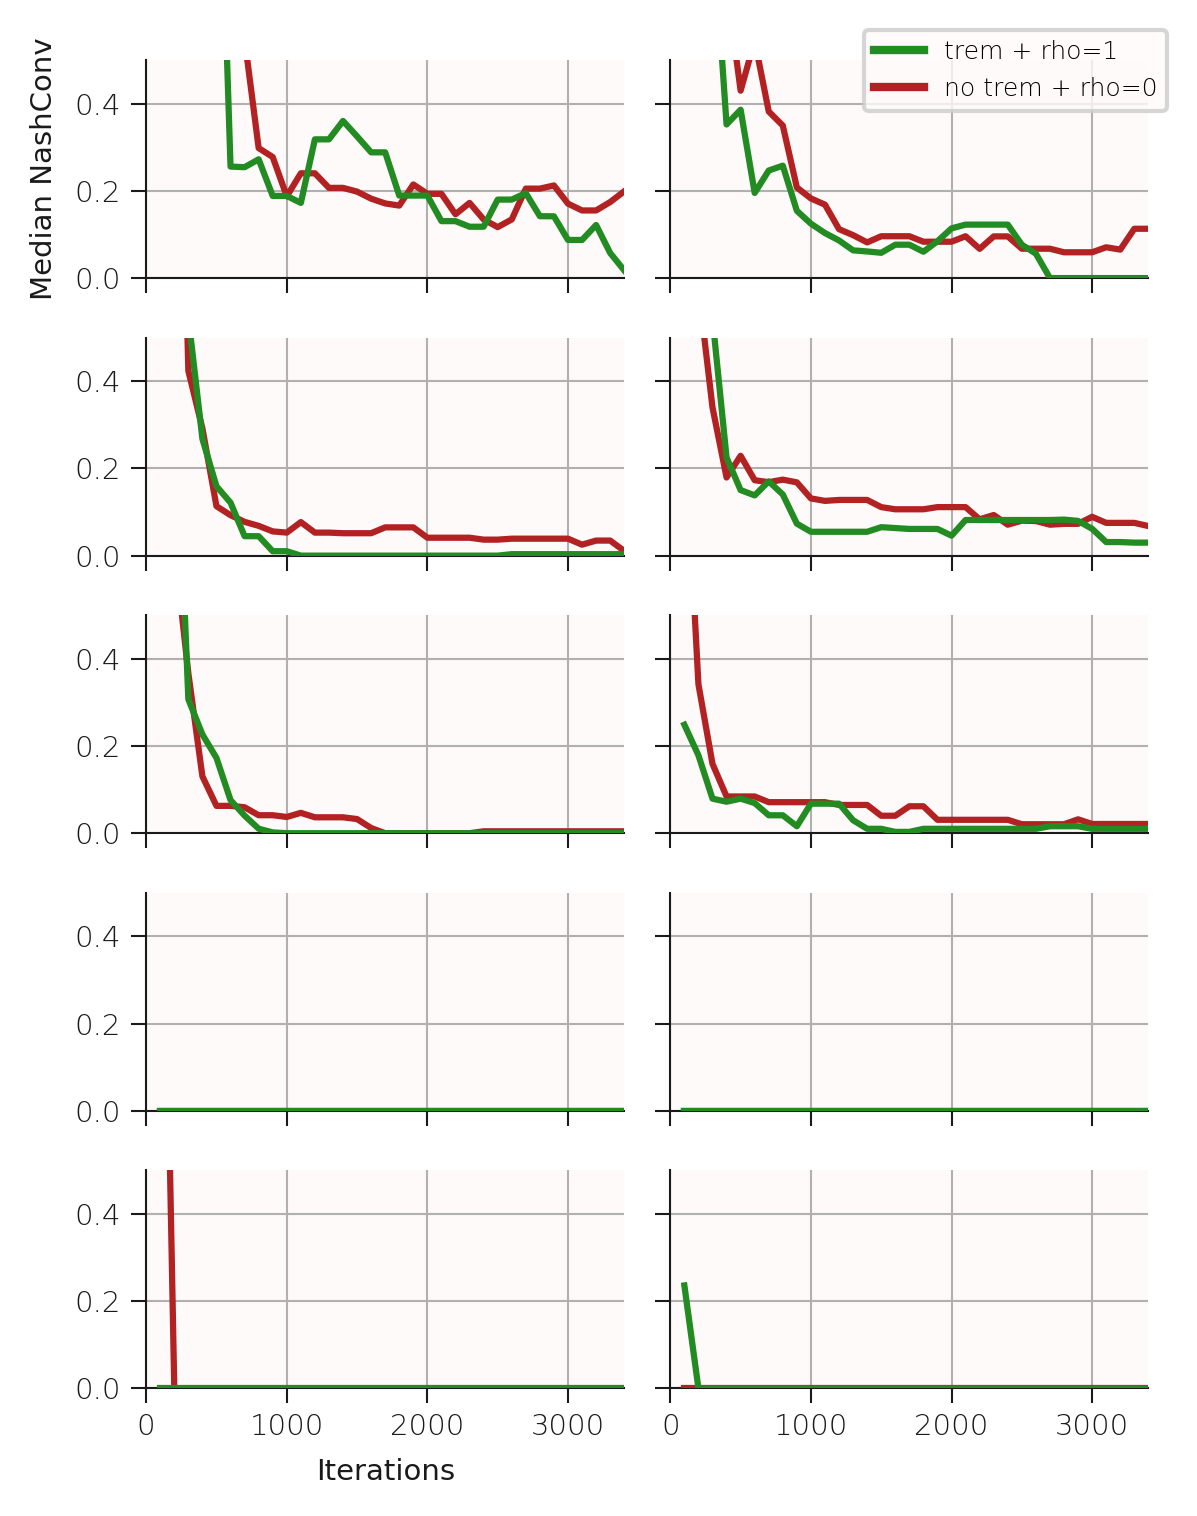

In [19]:
base_game_names = sorted(df['base_game_name'].unique())
rules = df['rule'].unique()
configs = df['cfg'].unique()

CFR_PRETTY_NAMES_AND_COLORS = {
    'cfr_10/external_plus_linear': ('trem + rho=1', 'forestgreen'),
    'cfr_10_no_trem/external_plus_linear_no_trem': ('no trem + rho=0', 'firebrick'),
}

MAX_STEPS = 3400
q_list = [0.1, 0.3, 0.5, 0.7, 0.9]
q = 0.7

fig, ax_list = plt.subplots(5, 2, figsize=(4, 5))
for i, (base_game_name, rule) in enumerate(itertools.product(base_game_names, rules)):
    plt.sca(ax_list.flatten()[i])
    for cfg in configs:
        sub_df = df[(df['base_game_name'] == base_game_name) & (df['rule'] == rule) & (df['cfg'] == cfg) & (df['global_step'] <= MAX_STEPS)]
        quantiles = sub_df.groupby('global_step')['nash_conv'].quantile(q_list).unstack()

        plt.plot(quantiles.index, quantiles[q], color=CFR_PRETTY_NAMES_AND_COLORS[cfg][1], clip_on=True, zorder=10)
        # for q_ in q_list:
        #     plt.plot(quantiles.index, quantiles[q_], color=CFR_PRETTY_NAMES_AND_COLORS[cfg][1], linewidth=0.5, alpha=0.5, clip_on=True, zorder=10)
        # plt.fill_between(quantiles.index, quantiles[0.1], quantiles[0.9], facecolor=CFG_TO_COLOR[cfg], alpha=0.2, clip_on=True, zorder=10)
    
    plt.xlim(0, MAX_STEPS)
    plt.ylim(0, 0.5)

ax_list[0, 0].set_ylabel('Median NashConv')
ax_list[-1, 0].set_xlabel('Iterations')
for iy, ix in itertools.product(range(5), range(2)):
    if ix != 0:
        ax_list[iy, ix].set_yticklabels([])
    if iy != len(ax_list) - 1:
        ax_list[iy, ix].set_xticklabels([])

fig.subplots_adjust(bottom=0.35)
custom_lines = [Line2D([0], [0], color=CFR_PRETTY_NAMES_AND_COLORS[p][1], lw=2) for p in CFR_PRETTY_NAMES_AND_COLORS]
fig.legend(custom_lines, [CFR_PRETTY_NAMES_AND_COLORS[p][0] for p in CFR_PRETTY_NAMES_AND_COLORS], loc='upper right', fontsize=6, bbox_to_anchor=(1,1), ncol=1)


plt.tight_layout()
plt.show()